In [1]:
import os
import cv2
import keras
import numpy as np
import pandas as pd
import random as rn
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import SVG
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import gc
from keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.python.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import DenseNet201

from tensorflow.keras import  layers, models



from sklearn.model_selection import train_test_split,KFold, cross_val_score, GridSearchCV
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Conv2D, MaxPool2D, Activation
from sklearn.utils import shuffle
from sklearn import metrics
#from sklearn.metrics import plot_confusion_matrix
from tensorflow.keras.utils import plot_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np

# Load the saved numpy arrays
x = np.load(r"/content/drive/MyDrive/Compare/x_data.npy")
y = np.load(r"/content/drive/MyDrive/Compare/y_data.npy")

# Now you can use x_loaded and y_loaded for further processing


In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
# split the data into training and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.2, random_state = 101, stratify=y)
y_train = to_categorical(y_train, num_classes = 2)
y_valid = to_categorical(y_valid, num_classes = 2)
del x,y #deletes the original x and y

In [5]:
# config the session
import tensorflow as tf

# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

# Set the numpy seed
np.random.seed(111)

# Set the random seed in tensorflow at graph level
tf.random.set_seed(111)
from random import seed
seed(111)

In [6]:
from keras import layers, Model, backend

channel_axis = -1  # color channels are expected to be the last dimension of the input data

def conv_block(input_tensor, filters, kernel_size, strides=(1, 1), name=None):
    """Convolution Block with BatchNormalization and ReLU activation."""
    if name is not None:
        conv_name = name + '_conv'
        bn_name = name + '_bn'
        act_name = name + '_act'
    else:
        conv_name = None
        bn_name = None
        act_name = None

    x = layers.Conv2D(filters, kernel_size,
                      strides=strides,
                      padding='same',
                      use_bias=False,
                      name=conv_name)(input_tensor)
    x = layers.BatchNormalization(axis=channel_axis, name=bn_name)(x)
    x = layers.Activation('relu', name=act_name)(x)

    return x

def residual_block(input_tensor, filters, kernel_size, strides=(1, 1), adjust_dimensions=False, block_name=None):
    """A Residual Block with optional dimension adjustment."""
    # Path to adjust dimensions if needed
    shortcut = input_tensor
    if adjust_dimensions:
        shortcut = layers.Conv2D(filters, (1, 1), strides=strides, padding='same', use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization(axis=channel_axis)(shortcut)

    # Main path
    x = conv_block(input_tensor, filters, kernel_size, strides=strides, name=f'{block_name}_conv1')
    x = conv_block(x, filters, kernel_size, strides=(1, 1), name=f'{block_name}_conv2')

    # Adding back the shortcut path
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

def build_model():
    img_input = layers.Input(shape=(224, 224, 3))

    # Initial Conv Block
    x = conv_block(img_input, 32, (3, 3), name='block1')
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='block1_pool')(x)

    # First Residual Block
    x = residual_block(x, 32, (3, 3), block_name='block2')

    # Further blocks can be added in a similar fashion
    # Notice we need to adjust dimensions when increasing the number of filters
    x = residual_block(x, 64, (3, 3), adjust_dimensions=True, strides=(2, 2), block_name='block3')

    # Continue building your model
    # For simplicity, adding one more block and then going to dense layers
    x = residual_block(x, 128, (3, 3), adjust_dimensions=True, strides=(2, 2), block_name='block4')
    x = layers.MaxPooling2D((3, 3), strides=(3, 3), padding='same', name='final_pool')(x)

    # Final Dense Layers
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(512, activation='relu', name='fc1')(x)
    x = layers.Dense(2, activation='softmax', name='predictions')(x)

    model = Model(inputs=img_input, outputs=x, name='model_with_skip_connections')
    return model

model = build_model()
model.summary()


Model: "model_with_skip_connections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv (Conv2D)        (None, 224, 224, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_bn (BatchNormalizat  (None, 224, 224, 32)         128       ['block1_conv[0][0]']         
 ion)                                                                                             
                                                                                                  
 block1_act (Activation)     (None, 224, 224, 32)         0         ['bl

In [7]:
LEARN_RATE = 1e-4
from tensorflow.keras.optimizers import Adam
model.compile(optimizer = Adam(lr = LEARN_RATE), loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy'])

In [8]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}.best_only.hdf5".format('save')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                              patience=5, verbose=1, mode='auto',
                              epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=40) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early,reduceLROnPlat]

In [9]:
#@title Default title text
history = model.fit(x_train,y_train,batch_size = 16,
                    epochs = 100, verbose=1,  validation_split=0.2, callbacks=callbacks_list)

Epoch 1/100
235/235 [==============================] - ETA: 0s - loss: 1.7319 - categorical_accuracy: 0.8833
Epoch 1: val_loss improved from inf to 3.13263, saving model to save.best_only.hdf5
235/235 [==============================] - 23s 63ms/step - loss: 1.7319 - categorical_accuracy: 0.8833 - val_loss: 3.1326 - val_categorical_accuracy: 0.7207 - lr: 0.0010
Epoch 2/100
234/235 [============================>.] - ETA: 0s - loss: 0.4168 - categorical_accuracy: 0.9228
Epoch 2: val_loss improved from 3.13263 to 2.46095, saving model to save.best_only.hdf5
235/235 [==============================] - 12s 50ms/step - loss: 0.4159 - categorical_accuracy: 0.9230 - val_loss: 2.4609 - val_categorical_accuracy: 0.7207 - lr: 0.0010
Epoch 3/100
235/235 [==============================] - ETA: 0s - loss: 0.1652 - categorical_accuracy: 0.9526
Epoch 3: val_loss improved from 2.46095 to 0.18565, saving model to save.best_only.hdf5
235/235 [==============================] - 12s 53ms/step - loss: 0.1652 -

In [10]:
# Save the entire model (architecture and weights)
model.save(r"/content/drive/MyDrive/Compare/pneumonia_skipconnection.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
#evaluates the trained model on a validation set and prints the test loss and accuracy.
test_loss, test_score = model.evaluate(x_valid, y_valid, batch_size=24)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)
#2304 seconds 50 epochs
#192 ms/step = average ms/step

49/49 [==============================] - 2s 34ms/step - loss: 0.2863 - categorical_accuracy: 0.9676
Loss on test set:  0.2863024175167084
Accuracy on test set:  0.9676044583320618


In [12]:
pred_y = model.predict(x_valid, callbacks=callbacks_list)

37/37 [==============================] - 2s 28ms/step


In [13]:
# Original labels
#checking the shapes of the original labels (orig_test_labels)
#and the predicted labels (pred_y).
orig_test_labels = np.argmax(y_valid, axis=-1)

print(orig_test_labels.shape)
print(pred_y.shape)

(1173,)
(1173, 2)


In [14]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_valid, axis = 1),np.argmax(pred_y, axis = 1)))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       317
           1       0.98      0.98      0.98       856

    accuracy                           0.97      1173
   macro avg       0.96      0.96      0.96      1173
weighted avg       0.97      0.97      0.97      1173



<Figure size 640x480 with 0 Axes>

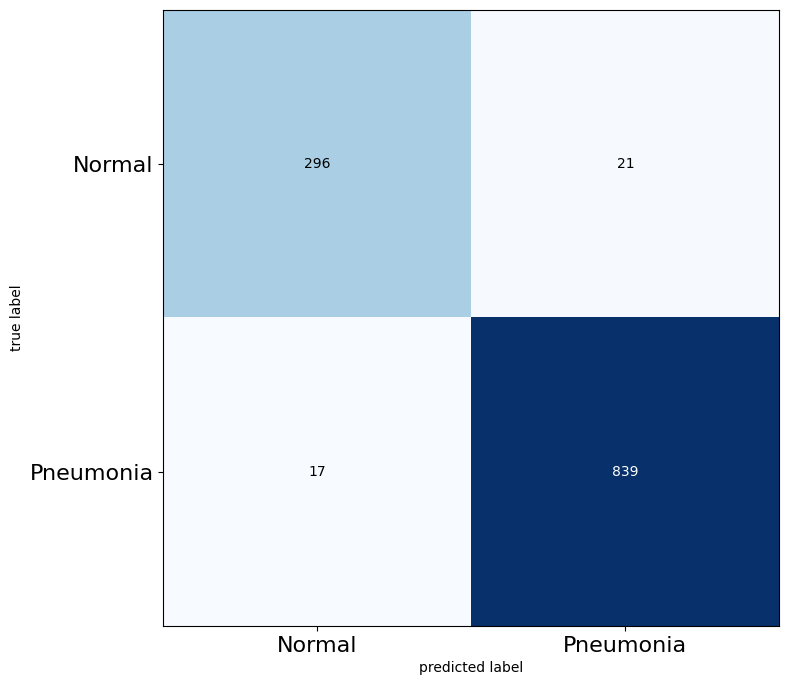

In [15]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
# Get the confusion matrix
cm  = confusion_matrix(np.argmax(y_valid, axis = 1), np.argmax(pred_y, axis = 1))
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [16]:
from sklearn.metrics import classification_report, precision_score

# Original labels
orig_test_labels = np.argmax(y_valid, axis=-1)

# Predicted labels
pred_labels = np.argmax(pred_y, axis=-1)

# Print classification report
print(classification_report(orig_test_labels, pred_labels))

# Calculate micro-averaged precision
micro_precision = precision_score(orig_test_labels, pred_labels, average='micro')
print(f"Micro-averaged Precision: {micro_precision}")


              precision    recall  f1-score   support

           0       0.95      0.93      0.94       317
           1       0.98      0.98      0.98       856

    accuracy                           0.97      1173
   macro avg       0.96      0.96      0.96      1173
weighted avg       0.97      0.97      0.97      1173

Micro-averaged Precision: 0.9676044330775788


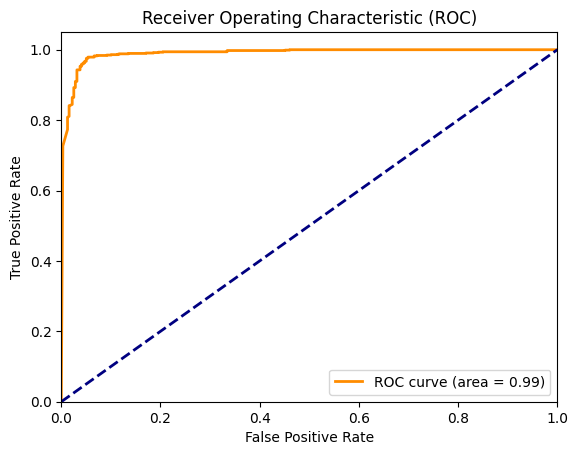

<Figure size 640x480 with 0 Axes>

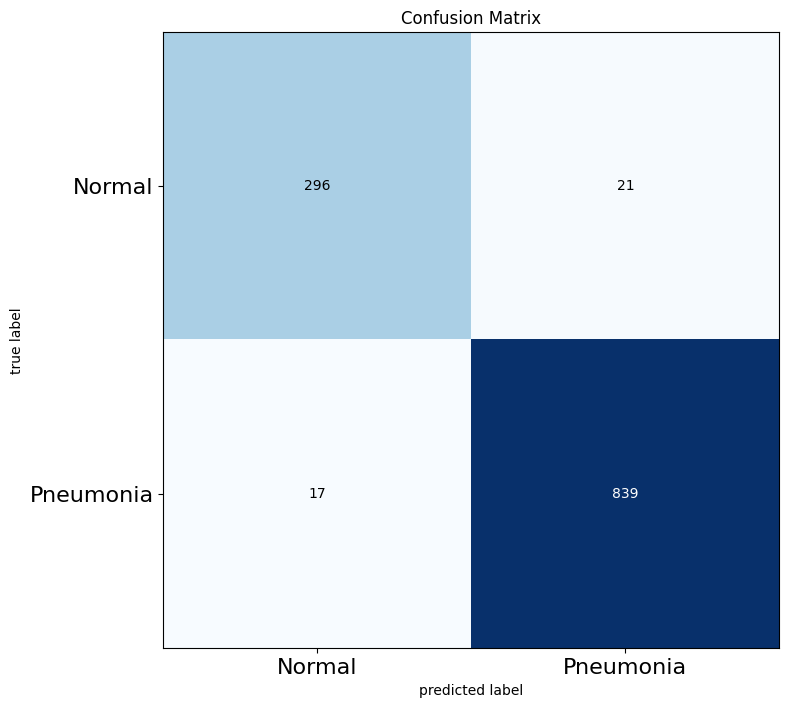

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
# 1. Compute ROC curve and AUC for each class
fpr, tpr, thresholds = roc_curve(y_valid[:, 1], pred_y[:, 1])
roc_auc = roc_auc_score(y_valid, pred_y)

# 2. Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# 3. Compute confusion matrix
# Convert probabilities to class labels
pred_labels = np.argmax(pred_y, axis=-1)

# Get the confusion matrix
cm = confusion_matrix(np.argmax(y_valid, axis=1), pred_labels)

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cm, figsize=(12, 8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.title('Confusion Matrix')
plt.show()


In [18]:
# Unpack the confusion matrix values
TN, FP, FN, TP = cm.ravel()

# Calculate Precision and Recall
precision = TP / (TP + FP)
recall = TP / (TP + FN)

# Calculate Accuracy
accuracy = (TP + TN) / float(TP + TN + FP + FN)

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the metrics with custom formatting
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")


Accuracy: 0.9676
Precision: 0.9756
Recall: 0.9801
F1-score: 0.9779


In [19]:
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.98
Precision of the model is 0.98


In [20]:
# Unpack the confusion matrix values
TN, FP, FN, TP = cm.ravel()

# Calculate Precision and Recall
precision = TP / (TP + FP)
recall = TP / (TP + FN)
# Calculate Accuracy
accuracy = (TP + TN) /(TP + TN + FP + FN)

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the metrics with custom formatting
print("Accuracy of the model is {:.2f}".format(accuracy))
print("Precision of the model is {:.2f}".format(precision))
print("Recall of the model is {:.2f}".format(recall))
print("F1-score of the model is {:.2f}".format(f1_score))


Accuracy of the model is 0.97
Precision of the model is 0.98
Recall of the model is 0.98
F1-score of the model is 0.98


In [21]:
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']


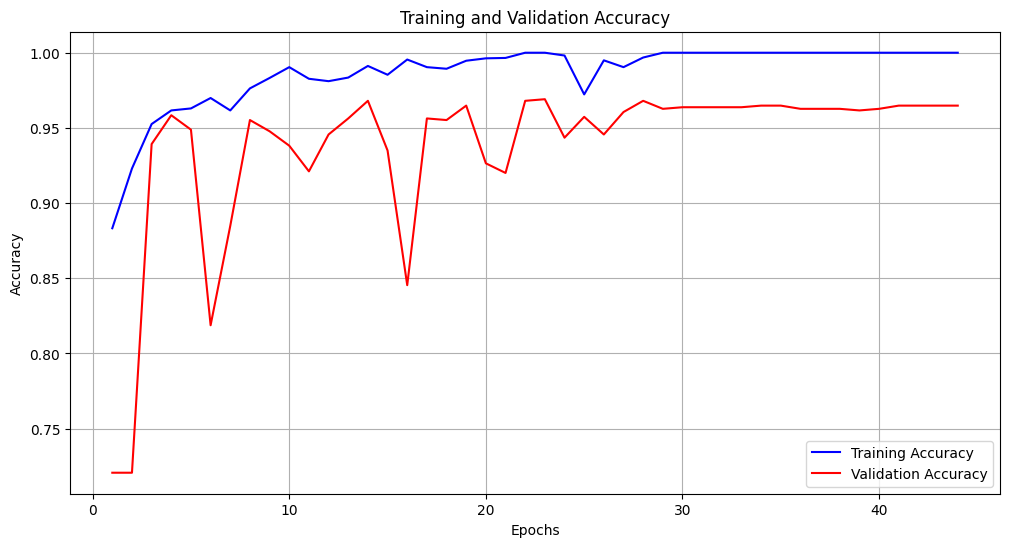

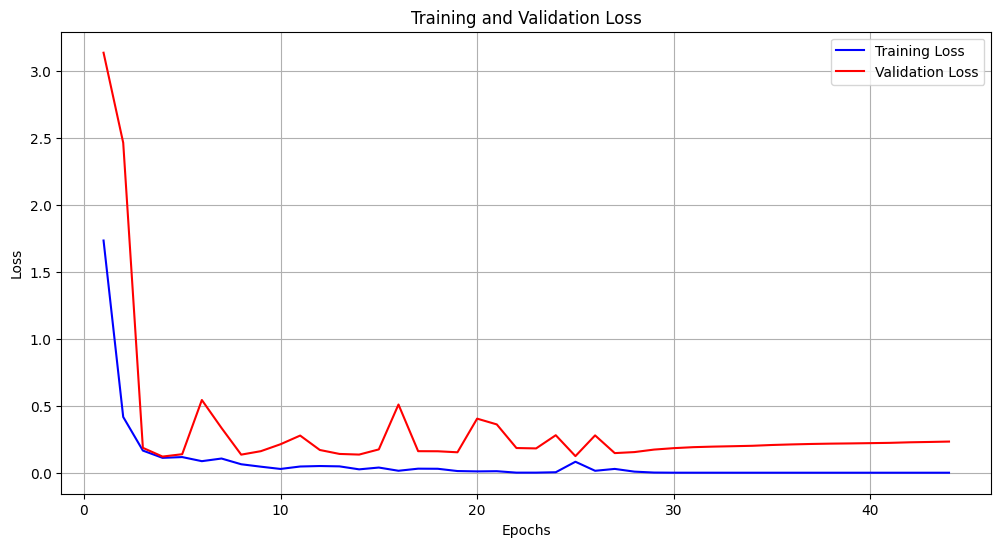

In [22]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
